In [1]:
# Initial imports
import pandas as pd
from path import Path



from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix




In [2]:
## Read data from database 'NBA_PLAYER_ANALYTICS'

In [3]:
# Read from players_stats and players_salary from database 


import sys
sys.path.append('../Pre-processing')
from db_connect import engine

players_stats_df = pd.read_sql('SELECT * FROM PLAYERS_STATS_F',engine)
players_stats_df.head(10)



players_stats_df.count()

player_id                          1036
playing_season                     1036
position                           1036
age                                1036
team                               1036
games_played                       1036
minutes_played                     1036
field_goals_made                   1036
field_goals_percentage             1036
three_points_made                  1036
three_points_attempted             1036
three_point_percentage             1036
effective_field_goal_percentage    1036
free_throw_percentage              1036
total_rebounds                     1036
assists                            1036
steals                             1036
blocks                             1036
turnovers                          1036
points                             1036
assist_to_turnover_ratio           1036
dtype: int64

In [4]:
players_to_ignore = pd.read_sql('SELECT distinct player_id FROM PLAYERS_SALARY_F WHERE SALARY = 0',engine)

player_to_ignore_list = [player_id[0] for idx,player_id in  players_to_ignore.iterrows()]

players_salary_df = pd.read_sql('SELECT * FROM PLAYERS_SALARY_F', engine)
players_salary_df = players_salary_df[players_salary_df['player_id'].isin(player_to_ignore_list)  == False]

#players_salary_df.count()

#players_salary_df['player_id'].unique()

In [5]:
# Read player stats and keeping them in dataframe

players_stats_df=players_stats_df.set_index('player_id')
players_stats_df

,playing_season,position,age,team,games_played,minutes_played,field_goals_made,field_goals_percentage,three_points_made,three_points_attempted,three_point_percentage,effective_field_goal_percentage,free_throw_percentage,total_rebounds,assists,steals,blocks,turnovers,points,assist_to_turnover_ratio
player_id,,,,,,,,,,,,,,,,,,,,
adamsst01,2016,C,23,OKC,80,29.9,4.7,0.571,0.0,0.000,0.571,2.0,0.611,7.7,1.1,1.1,1.0,1.8,11.3,1.0
aldrila01,2016,PF,31,SAS,72,32.4,6.9,0.477,0.3,0.411,0.488,3.1,0.812,7.3,1.9,0.6,1.2,1.4,17.3,1.0
aminual01,2016,PF,26,POR,61,29.1,3.0,0.393,1.1,0.330,0.468,1.6,0.706,7.4,1.6,1.0,0.7,1.5,8.7,1.0
anderju01,2016,SF,23,TOT,75,16.4,2.5,0.424,0.8,0.299,0.490,1.4,0.791,3.3,0.9,0.5,0.3,0.9,7.1,1.0
anderky01,2016,SF,23,SAS,72,14.2,1.3,0.445,0.2,0.375,0.481,0.6,0.789,2.9,1.3,0.7,0.4,0.5,3.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
caulewi01,2019,C,26,TOT,54,20.3,3.2,0.579,0.0,0.000,0.579,0.7,0.606,5.8,1.3,0.9,1.1,0.7,7.2,1.0
hernawi01,2019,C,25,CHO,31,12.1,2.4,0.532,0.2,0.227,0.550,1.2,0.627,4.3,0.9,0.3,0.2,1.0,6.1,1.0
chandwi01,2019,PF,32,BRK,35,21.0,2.1,0.404,1.1,0.306,0.505,0.6,0.870,4.1,1.1,0.5,0.3,1.0,5.9,1.0


## Prepare data for Supervised Machine Learning

In [6]:
# Aggregate(Average) the player statistcics so that PLayer statistics can be fed to machine learning algorithm
player_stats_avg_df= players_stats_df.groupby(['player_id']).mean()[['games_played','minutes_played','field_goals_percentage','three_point_percentage',''\
          'effective_field_goal_percentage','free_throw_percentage','total_rebounds','assists','steals','blocks',\
          'turnovers','points']]

player_stats_avg_df.head()
players_salary_df=players_salary_df.set_index('player_id')
players_salaries_avg_df= players_salary_df.groupby(['player_id']).mean()['salary']
players_salaries_avg_df

player_id
adamsst01    18903107.25
aldrila01    22595757.50
aminual01     7803776.25
anderju01     1476019.75
anderky01     5264458.50
                ...     
wrighde01     3808265.50
youngth01    12916011.25
zelleco01    11475645.75
zellety01     3318408.00
zubaciv01     2593477.25
Name: salary, Length: 245, dtype: float64

In [7]:
#Merge Player Statistics and Player Salary so that they are merged and kept in one data frame
player_stats_with_salary = player_stats_avg_df.merge(players_salaries_avg_df, left_index=True,right_index=True)
player_stats_with_salary.head()

,games_played,minutes_played,field_goals_percentage,three_point_percentage,effective_field_goal_percentage,free_throw_percentage,total_rebounds,assists,steals,blocks,turnovers,points,salary
player_id,,,,,,,,,,,,,
adamsst01,74.75,30.675,0.59675,0.59700,1.950,0.56300,8.875,1.550,1.150,1.025,1.675,12.500,18903107.25
aldrila01,70.25,33.050,0.49975,0.51550,3.725,0.83075,8.100,2.175,0.600,1.325,1.525,20.150,22595757.50
aminual01,57.25,27.125,0.37800,0.45700,1.375,0.74150,6.825,1.325,0.975,0.525,1.100,7.925,7803776.25
anderju01,42.75,12.600,0.38150,0.45775,0.700,0.69275,2.400,0.725,0.350,0.350,0.550,4.950,1476019.75
anderky01,64.00,22.650,0.49725,0.52525,0.925,0.68650,4.600,2.350,1.100,0.675,1.025,6.275,5264458.50


In [8]:
player_stats_with_salary.count()

games_played                       245
minutes_played                     245
field_goals_percentage             245
three_point_percentage             245
effective_field_goal_percentage    245
free_throw_percentage              245
total_rebounds                     245
assists                            245
steals                             245
blocks                             245
turnovers                          245
points                             245
salary                             245
dtype: int64

In [9]:
# Function to label the Salary increased YORN (Increase -1  and Decrease -2) per each player
def salary_increased_or_not_labeling(player_id):
     
    
    first_playing_season =  players_salaries_reset_df[(players_salaries_reset_df['player_id'] == player_id)]['playing_season'].min()  

        
    first_season_salary = players_salaries_reset_df[(players_salaries_reset_df['playing_season'] ==first_playing_season)\
                                      &  (players_salaries_reset_df['player_id'] ==player_id)]['salary'].min()                          
                                            
   
    last_playing_season =  players_salaries_reset_df[(players_salaries_reset_df['player_id'] == player_id)]['playing_season'].max()  

    
    
    last_season_salary = players_salaries_reset_df[(players_salaries_reset_df['playing_season'] ==last_playing_season)\
                                      &  (players_salaries_reset_df['player_id'] ==player_id)]['salary'].max()                           

    
    # find out the raio of last year cap /first year salary cap so that salaries can be standardized to be compared
    
    query_to_find_out_first_year_cap = f'SELECT SALARY FROM public.nba_per_year_salary_cap WHERE PLAYING_SEASON={first_playing_season}'
    first_year_cap = pd.read_sql(query_to_find_out_first_year_cap,engine)                  
    first_year_cap_value = first_year_cap['salary'].values[0]
    
    
    query_to_find_out_last_year_cap = f'SELECT SALARY FROM public.nba_per_year_salary_cap WHERE PLAYING_SEASON={last_playing_season}'
    last_year_cap = pd.read_sql(query_to_find_out_last_year_cap,engine)                  
    last_year_cap_value = last_year_cap['salary'].values[0]
    
 
    ratio_to_standardize = round(last_year_cap_value/first_year_cap_value,2)
  
    
    # Compare the Salary (If Salary increased then return 1, if decreased then return 2 and if remains same then 0)
    
    first_season_salary_standardized = first_season_salary * ratio_to_standardize
    
    if (last_season_salary > first_season_salary_standardized):
        return 1   
    else: #(last_season_salary < first_season_salary_standardized):
        return 2
    #else:    
    #    return 0

In [10]:
# Prepare the dataset and add the labeling for Machine Learning

import warnings
warnings.filterwarnings('ignore')

players_salaries_reset_df = players_salary_df.reset_index(['player_id'])

player_stats_with_salary_aggregated = player_stats_with_salary.reset_index(['player_id'])
player_stats_with_salary_aggregated['salary_increased_yorn'] = player_stats_with_salary_aggregated['player_id'].apply(salary_increased_or_not_labeling)
#player_stats_with_salary_forML= player_stats_with_salary_aggregated.set_index(['player_id']).dropna()
player_stats_with_salary_forML= player_stats_with_salary_aggregated.set_index(['player_id'])
player_stats_with_salary_forML


,games_played,minutes_played,field_goals_percentage,three_point_percentage,effective_field_goal_percentage,free_throw_percentage,total_rebounds,assists,steals,blocks,turnovers,points,salary,salary_increased_yorn
player_id,,,,,,,,,,,,,,
adamsst01,74.75,30.675,0.59675,0.59700,1.950,0.56300,8.875,1.550,1.150,1.025,1.675,12.500,18903107.25,1
aldrila01,70.25,33.050,0.49975,0.51550,3.725,0.83075,8.100,2.175,0.600,1.325,1.525,20.150,22595757.50,1
aminual01,57.25,27.125,0.37800,0.45700,1.375,0.74150,6.825,1.325,0.975,0.525,1.100,7.925,7803776.25,1
anderju01,42.75,12.600,0.38150,0.45775,0.700,0.69275,2.400,0.725,0.350,0.350,0.550,4.950,1476019.75,2
anderky01,64.00,22.650,0.49725,0.52525,0.925,0.68650,4.600,2.350,1.100,0.675,1.025,6.275,5264458.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrighde01,61.00,20.375,0.44575,0.49825,1.425,0.78900,3.000,2.900,1.100,0.400,1.000,7.300,3808265.50,1
youngth01,75.00,29.500,0.49725,0.53775,0.775,0.58700,5.950,1.950,1.525,0.400,1.425,11.425,12916011.25,2
zelleco01,50.50,23.825,0.54775,0.55600,2.075,0.71650,6.450,1.525,0.725,0.675,1.150,9.650,11475645.75,1


In [11]:
# Create X (Features) & y (Target) for Machine Learning
x_cols = [i for i in player_stats_with_salary_forML.columns if i not in ('salary_increased_yorn','salary','blocks')]  

X = player_stats_with_salary_forML[x_cols]
#X.describe()

y=player_stats_with_salary_forML['salary_increased_yorn']


In [12]:
player_stats_with_salary_forML['salary_increased_yorn'].value_counts()

1    160
2     85
Name: salary_increased_yorn, dtype: int64

## Use RandomForest to train and test the Predictions

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Scale two columns 'games_played' and 'minutes_played' for feeding them to Machine learning Algorithm Random Forest
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = X
X_scaled[['games_played', 'minutes_played']] = min_max_scaler.fit_transform(X_scaled[['games_played', 'minutes_played']])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=1)

# Use Random Forest algorithm to train and predict
clf = RandomForestClassifier(n_estimators=150,random_state=1)
clf.fit(X_train, y_train)  
y_pred=clf.predict(X_test)


# Calculated the accuracy score

from sklearn.metrics import balanced_accuracy_score
accuracy_score(y_test, y_pred)




0.7346938775510204

In [14]:
# Create Consuion Metrics

confusion_matrix(y_test,y_pred)

array([[28,  9],
       [ 4,  8]], dtype=int64)

## Study the feature dependecies 

In [15]:
# Find out the percentage of contribution of each and every features used. 

mapping={}
for columns,values in zip(X.columns,clf.feature_importances_):
    mapping[columns] = values
    


In [16]:
mapping

{'games_played': 0.08274173007190047,
 'minutes_played': 0.11992683626017608,
 'field_goals_percentage': 0.09116837351249878,
 'three_point_percentage': 0.07225717600720466,
 'effective_field_goal_percentage': 0.10793959121348054,
 'free_throw_percentage': 0.07870171120849292,
 'total_rebounds': 0.08073248489603109,
 'assists': 0.07569973145181784,
 'steals': 0.10156532911090214,
 'turnovers': 0.09130037397056526,
 'points': 0.09796666229693032}

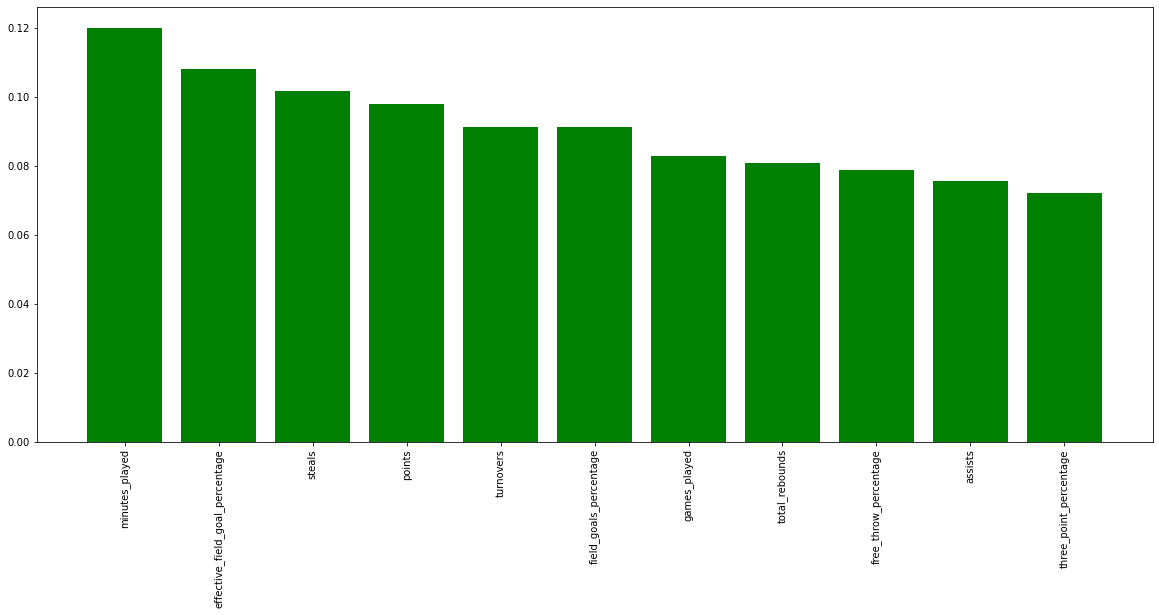

In [41]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

d = dict(zip(X.columns,clf.feature_importances_))
x = sorted(d, key=d.get, reverse=True)

plt.bar(x, [d[i] for i in x], color="g", align="center")

plt.xticks(rotation='vertical')



fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 8)


## Use different Sampling Techniques(SMOTE and SMOTEEN) to study whether it improvises Accuracy Scores or not

In [ ]:
# Resample (Oversample) the training data with SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter


X_resampled, y_resampled = SMOTE(random_state=1).fit_resample(
    X_train, y_train
)

Counter(y_resampled)


clf.fit(X_resampled, y_resampled)  

y_pred=clf.predict(X_test)


# Calculated the accuracy score

from sklearn.metrics import balanced_accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
# Combination of Samplling using SMOTEEN

from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)


clf.fit(X_resampled, y_resampled)  

y_pred=clf.predict(X_test)


# Calculated the accuracy score

from sklearn.metrics import balanced_accuracy_score
accuracy_score(y_test, y_pred)


## Use Logistic Regression for machine learning

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier

classifier.fit(X_train, y_train)



from sklearn.metrics import balanced_accuracy_score
accuracy_score(y_test, y_pred)
